![logo](./img/LogoLine_horizon_CAMS.png)

# Profile Plots and Zonal Means

This tutorial demonstrates how to visualise [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/) data of different atmospheric levels in the form of profile plots and zonal mean plots. The data used in this tutorial includes CO from the Northern Hemisphere during the summer (peak fire season) from 2003 to 2021.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-profiles.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-profiles.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-profiles.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## Install and import packages

In [ ]:
!pip install cdsapi

In [2]:
# CDS API
import cdsapi

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.pyplot as plt

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Data access and preprocessing

### Download CAMS global reanalysis data

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads.atmosphere.copernicus.eu/ and obtain an API key from https://ads.atmosphere.copernicus.eu/how-to-api.)

In [3]:
URL = 'https://ads.atmosphere.copernicus.eu/api'

# Replace the hashtags with your key:
KEY = '#################################'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [4]:
DATADIR = '.'

For this tutorial, we will use CAMS Global Reanalysis (EAC4) data. The code below shows the subset characteristics that we will extract from this dataset as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [5]:
dataset = "cams-global-reanalysis-eac4-monthly"
request = {
    'variable': ['carbon_monoxide'],
    'pressure_level': ['100', '150', '200', '250', 
                       '300', '400', '500', '600', 
                       '700', '800', '850', '900', 
                       '925', '950', '1000'],
    'year': ['2003', '2004', '2005', '2006', 
             '2007', '2008', '2009', '2010', 
             '2011', '2012', '2013', '2014', 
             '2015', '2016', '2017', '2018', 
             '2019', '2020', '2021', '2022', 
             '2023'],
    'month': ['06', '07', '08'],
    'product_type': ['monthly_mean'],
    'data_format': 'netcdf'
}

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(
    f'{DATADIR}/CO_NHemis_JJA_2003-2023.nc')

2024-09-12 14:27:56,029 INFO Request ID is d917161b-fe2e-4e8c-9cf7-7ffb41e0855e
2024-09-12 14:27:56,215 INFO status has been updated to accepted
2024-09-12 14:27:58,031 INFO status has been updated to running
2024-09-12 14:29:50,536 INFO Creating download object as as_source with files:
['data_allhours_plev.nc']
2024-09-12 14:29:50,538 INFO status has been updated to successful


4d7fda9863851e189ea094742d844eff.nc:   0%|          | 0.00/236M [00:00<?, ?B/s]

'./CO_NHemis_JJA_2003-2023.nc'

### Read and inspect data

Read the data into an Xarray dataset:

In [6]:
fn = f'{DATADIR}/CO_NHemis_JJA_2003-2023.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset> Size: 437MB
Dimensions:         (valid_time: 63, pressure_level: 15, latitude: 241,
                     longitude: 480)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 504B 2003-06-01 ... 2023-08-01
  * pressure_level  (pressure_level) float64 120B 1e+03 950.0 ... 150.0 100.0
  * latitude        (latitude) float64 2kB 90.0 89.25 88.5 ... -89.25 -90.0
  * longitude       (longitude) float64 4kB 0.0 0.75 1.5 ... 357.8 358.5 359.2
Data variables:
    co              (valid_time, pressure_level, latitude, longitude) float32 437MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-12T14:29 GRIB to CDM+CF via cfgrib-0.9.1...

### Representation of pressure levels

Our CO dataset represents 15 levels of the atmosphere, from 1000 (surface) to 100 hectopascals (hPa). This can be best visualised in a logarithmic scale, or if converted to altitude.

#### Pressure levels in logarithmic scale

Here we create a new coordinate of our Data Array with the logarithm of the pressure levels, to facilitate visualisation in our plots.

In [7]:
ds['level_log10'] = np.log10(ds['pressure_level'])

In [8]:
ds = ds.set_coords('level_log10')

#### Pressure levels to altitude

Here we create a new coordinate with altitude. The altitude in meters can be calculated with the international barometric formula:

H = 44330 * [1 - (P/p0)^(1/5.255) ]

Where H = altitude (m), P = measured pressure (Pa) from the sensor, and p0 = reference pressure at sea level (e.g. 1000 hPa)

Here we shall assume that the reference pressure at sea level is 1000 hPa.

In [9]:
ds['height'] = 44330. * (1 - ((ds['pressure_level']/1000.)**(1/5.255)))

We will convert the heights from meters to kilometers:

In [10]:
ds['height'] = ds['height']/1000.

Here we set the heights as a coordinate in our Xarray Dataset.

In [11]:
ds = ds.set_coords('height')

### Convert xarray Dataset into Data Array

To facilitate later processing, we will now convert this xarray Dataset into an Xarray Data Array object. This is an object which allows more options for processing data of only one variable, in this case CO.

In [12]:
da = ds['co']

In [13]:
da

<xarray.DataArray 'co' (valid_time: 63, pressure_level: 15, latitude: 241,
                        longitude: 480)> Size: 437MB
[109317600 values with dtype=float32]
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 504B 2003-06-01 ... 2023-08-01
  * pressure_level  (pressure_level) float64 120B 1e+03 950.0 ... 150.0 100.0
  * latitude        (latitude) float64 2kB 90.0 89.25 88.5 ... -89.25 -90.0
  * longitude       (longitude) float64 4kB 0.0 0.75 1.5 ... 357.8 358.5 359.2
    level_log10     (pressure_level) float64 120B 3.0 2.978 2.966 ... 2.176 2.0
    height          (pressure_level) float64 120B 0.0 0.4306 ... 13.43 15.73
Attributes: (12/32)
    GRIB_paramId:                             210123
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      115680
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Carbon monoxide mass mixing ratio
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_carbon_monoxid...
    GRIB_number:                              0

### Unit conversion

Most of the chemical species in the CAMS Global data, including our CO data, is archived as mass mixing ratios (MMR, kg of gas / kg of air).

We will convert this to Volume Mixing Ratio (VMR, in units parts per billion, or ppbv)

To convert data from MMR to VMR you only need the molar masses of dry air and of the atmospheric species. For CO the formula is: VMR = 28.9644 / 28.0101 * 1e9 * MMR. The 1e9 in the formulae gives parts per billion (ppbv). If we wanted parts per million (ppmv) we would use 1e6. See [more details on unit conversions here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710).

In [14]:
da = (28.9644 / 28.0101) * 1e9 * da

Here we update the attributes of our dataset with the new units.

In [15]:
da.attrs['long_name'] = 'CO Volume Mixing Ratio'
da.attrs['units'] = 'ppbv'

### Subset and aggregation

We would like to visualise CO profiles over the northern hemisphere, so we will take a subset including only northern latitudes. Also, to facilitate visualisation of CO vertical profiles, we are going to average over the temporal and spatial dimensions.

#### Spatial subset

Here we subset the data to keep only northern latitudes.

In [16]:
da_north = da.where(da.latitude > 0, drop=True)

#### Temporal aggregation

The purpose of the temporal aggregation is to average June, July and August in each year, resulting in one summer mean value at each year of the dataset.

In [17]:
summer = da_north.groupby('valid_time.year').mean(keep_attrs=True)

#### Spatial aggregation

To visualise the data in a profile plot, we will aggregate over the spatial dimensions. For the latitudinal dimension, we need to take into account the variation in area as a function of latitude, which we will do by taking the cosine of the latitude as a proxy.

In [18]:
weights = np.cos(np.deg2rad(summer.latitude))
weights.name = "weights"
weighted = summer.weighted(weights)

In [19]:
# Average (mean) over the latitudinal axis
co = weighted.mean(dim=["latitude", "longitude"])

### Calculate quantiles of climatology

Here we calculate the 5th, 50th and 95th quantile of CO climatology from 2003 to 2023.

In [20]:
co95 = co.quantile(0.95, dim='year')
co05 = co.quantile(0.05, dim='year')
co50 = co.quantile(0.5, dim='year')

## Plot summer climatology of CO in Northern Hemisphere

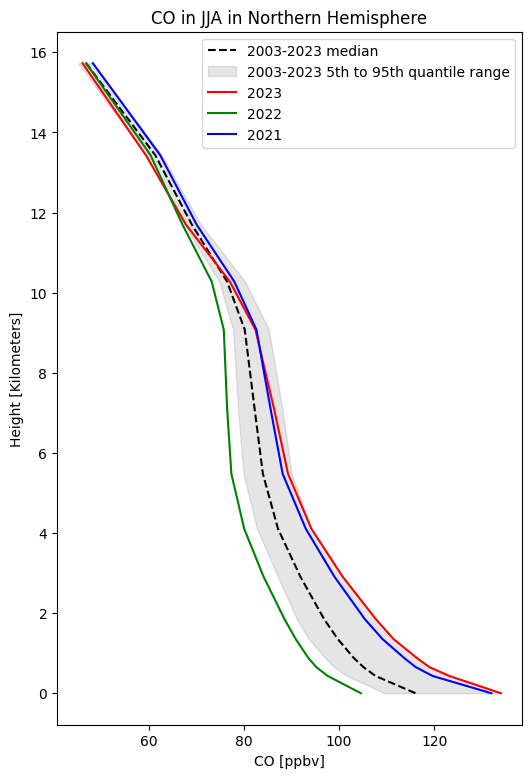

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (6, 9))

ax.set_title('CO in JJA in Northern Hemisphere', fontsize=12)
ax.set_ylabel('Height [Kilometers]')
ax.set_xlabel('CO [ppbv]')
ax.plot(co50, co50.height, color='black', linestyle='--', label='2003-2023 median')
ax.fill_betweenx(co50.height, co05, co95, alpha=0.1, color='black', label='2003-2023 5th to 95th quantile range')
ax.plot(co[20,:], co.height, color='red', linestyle='-', label='2023')
ax.plot(co[19,:], co.height, color='green', linestyle='-', label='2022')
ax.plot(co[18,:], co.height, color='blue', linestyle='-', label='2021')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

fig.savefig(f'{DATADIR}/CO_JJA_NHem_2003-2023_profile.png')

Note the distribution of CO mainly in the lower part of the atmosphere, and the high values in 2021 and 2023, due mainly to the significant wildfire activity those summers. See the [BAMS State of the Climate reports](https://www.ncei.noaa.gov/bams-state-of-climate) for more details.

## Create zonal mean plot of CO summer climatology in Northern Hemisphere

### Data prep

We again aggregate over time (June, July and Aug of each year), and over space. This time however the spatial aggregation is only over the longitudinal dimension, as we want to visualise data over all latitudinal zones.

In [23]:
jja = da.groupby('valid_time.year').mean(keep_attrs=True)

In [24]:
zonal = jja.mean(dim=["longitude", "year"])

### Create zonal mean plot

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [25]:
vdiv = 10
vmin = 50
vmax = 200+vdiv
clevs = np.arange(vmin,vmax,vdiv)

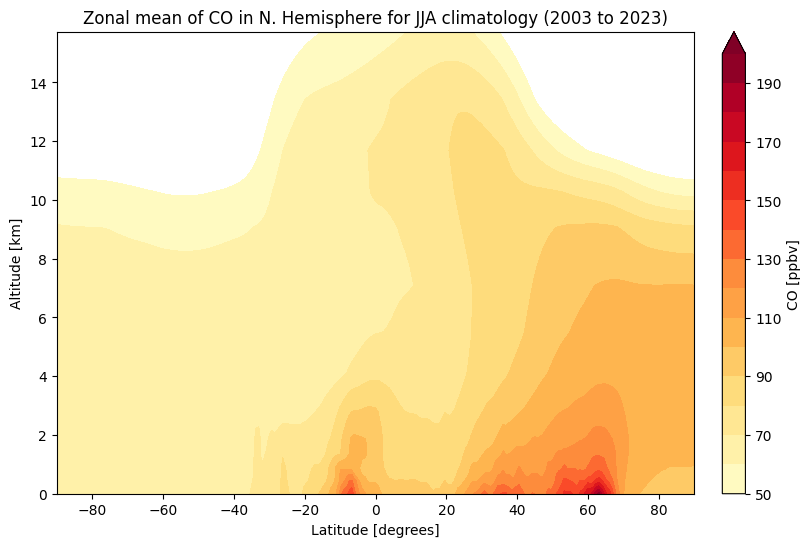

In [26]:
# Define the figure and specify size
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

# Configure the axes and figure title
ax.set_xlabel('Latitude [degrees]')
ax.set_ylabel('Altitude [km]')
ax.set_title('Zonal mean of CO in N. Hemisphere for JJA climatology (2003 to 2023)', fontsize=12)

# As the altitudes (15) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax.set_aspect('auto')

# Plot the data as a contour plot
contour = ax.contourf(zonal.latitude, zonal.height, zonal, levels=clevs, cmap='YlOrRd', extend='max')

# Specify the colourbar
cbar = plt.colorbar(contour,fraction=0.046, pad=0.04)
cbar.set_label('CO [ppbv]')

# Save the plot
fig.savefig(f'{DATADIR}/CO_JJA_NHem_2003-2023_zonal_mean.png')

Note the greater abundance of CO in the northern hemisphere, and in the lower part of the atmosphere.